# Klausur

## Task 1

In [1]:
using Plots
using FFTW

In [268]:
"Computes gradient of a 2D scalar field"
function f_grad(T,Nx, Ny, Lx, Ly)
    diff_x = fill(0.0, (Nx,Ny))
    diff_y = fill(0.0, (Nx,Ny))
    diff = fill([0.0], (Nx,Ny))

    # Derivative in x direction
    for i in 1:size(T,2)
        diff_x[:,i] = f_diff(T[:,i],Nx,Lx)
    end

    # Derivative in y direction
    for i in 1:size(T,1)
        diff_y[i,:] = f_diff(T[i,:],Ny,Ly)
    end

    # Combines derivatives into vector field
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            diff[i,j] = [diff_x[i,j],diff_y[i,j]]
        end
    end

    return diff
end


"Differentiates in fourier space"
function f_diff(x,N,L)
    k = fftfreq(N)*N
    diff = ifft(2*pi*im/L*k.*fft(x))
    return real(diff)
end

"Returns real fourier coeffs of v⋅∇T"
function v∇T(v,T,Nx,Ny,Lx,Ly)
    ∇T = f_grad(T,Nx,Ny,Lx,Ly)
    return fft(scalarProductVecField(v,∇T))
end

"Computes the element-wise scalar product of two vector fields"
function scalarProductVecField(a,b)
    return getindex.(a,1).*getindex.(b,1) + getindex.(a,2).*getindex.(b,2)
end

"Q"
function sourceTerm(x,y)
    return -2*pi^2*sin(4*pi*x)*cos(2*pi*y)*sin(2*pi*x)*sin(2*pi*y) - 4*pi^2*cos(4*pi*x)*sin(2*pi*y)*cos(2*pi*x)*cos(2*pi*y) + 4*pi^2*cos(2*pi*x)*sin(2*pi*y) + 4*pi^2*cos(2*pi*x)*sin(2*pi*y)
end

"Source term Q in fourier space"
function Q_hat(Nx,Ny,Lx,Ly)
    Q = fill(0.0,Nx,Ny)
    for i in 1:Nx
        for j in 1:Ny
            Q[i,j] = sourceTerm(Lx/Nx*i,Ly/Ny*j)
        end
    end
    return fft(Q)
end

"Time step of the temperature field"
function T_step(T_hist,v_hist,hats,Nx,Ny,Lx,Ly,Δt,Q)
    # Wave Vectors #
    kx = fftfreq(Nx)*Nx
    ky = fftfreq(Ny)*Ny

    # Calculate ℱ(v⋅∇T) #
    push!(hats,v∇T(v_hist[end],real(ifft(T_hist[end])),Nx,Ny,Lx,Ly))

    T = T_hist[end]
    T_new = copy(T)
   
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            T_new[i,j] = (1 + Δt*0.5*sqrt(kx[i]^2+ky[j]^2)^2)^(-1) * (T[i,j] + Δt*(-0.5*sqrt(kx[i]^2+ky[j]^2)^2 * T[i,j] - 0.5*(3*hats[end][i,j] - hats[end-1][i,j]) + Q[i,j]))
        end
    end
    
    return T_new
end


T_step

┌ Info: Saved animation to 
│   fn = /home/jovyan/tmp.gif
└ @ Plots /opt/julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/home/jovyan/tmp.gif")
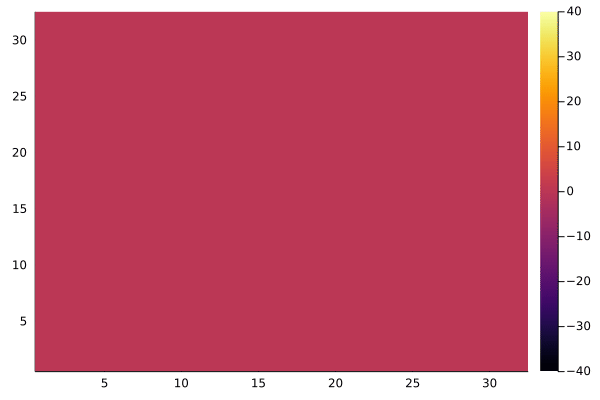

In [271]:
function test_function()
    Nx = 32
    Ny = 32
    Lx = 1
    Ly = 1


    # Initial temperature field #
    T = fill(0.0, (Nx,Ny))
    for i in 1:Nx
        for j in 1:Ny
            T[i,j] = 0
        end
    end

    # Initial velocity field #
    v = fill([0.0,0.0], (Nx,Ny))
    for i in 1:Nx
        for j in 1:Ny
            v[i,j][1] = pi*sin(4*pi*Lx/Nx*i)*cos(2*pi*Lx/Ny*j)
            v[i,j][2] = -2*pi*cos(4*pi*Lx/Nx*i)*sin(2*pi*Lx/Ny*j)
        end
    end

    T_hist = [fft(copy(T)),fft(copy(T))]
    v_hist = [copy(v),copy(v)]
    hats = [v∇T(v_hist[end - 1],real(ifft(T_hist[end - 1])),Nx,Ny,Lx,Ly)]
    Q = Q_hat(Nx,Ny,Lx,Ly)
    for in in 1:300
        push!(T_hist,T_step(T_hist,v_hist,hats,Nx,Ny,Lx,Ly,0.01,Q))
    end
    
    @gif for h in T_hist
       heatmap(real(ifft(h)),clim=(-40,40))
    end every 30

    #maxx = []
    #for h in T_hist
    #    append!(maxx,maximum(h))
    #end
    #display(plot(maxx))

end
test_function()


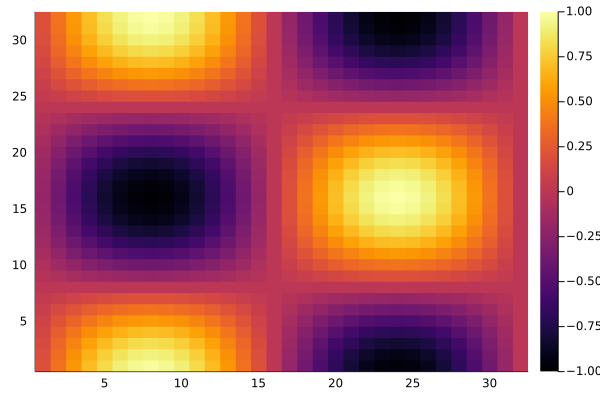

In [252]:
Nx = 32
Ny = 32
Lx = 1
Ly = 1

target = fill(0.0, (Nx,Ny))
for i in 1:Nx
    for j in 1:Ny
        target[i,j] = cos(2.0*pi*Lx/Nx*i)*sin(2*pi*Ly/Ny*j)
    end
end
display(heatmap(target))